# Socioeconomic Deprivation and Urban Green Space Accessibility: A Spatial Analysis of Park Proximity in Leeds

**Introduction**

Urban green space (UGS) is widely recognized as a key infrastructure for improving residents' mental health, air quality, and social interaction, and the equity of its accessibility directly impacts residents' quality of life and social inclusion. However, in the process of urbanization, "environmental injustice" often leads to significant differences in the enjoyment of natural resources among groups from different socioeconomic backgrounds.

This study uses Leeds, UK as a case study, and quantitatively analyzes the relationship between community wealth and distance to the nearest park by integrating geospatial data from the 2019 Index of Multiple Deprivation (IMD) and OpenStreetMap (OSM). The aim is to explore whether there is inequality in the allocation of spatial resources in Leeds, provide a basis for urban planning departments to optimize resource allocation, and ultimately promote the realization of the goal of equitable sharing of public resources.

**Data Sources**

**Socioeconomic data：** The UK Deprivation Index 2019 was provided by the Department for Housing, Communities and Local Government. This dataset identifies the Multiple Deprivation Index (IMD) at the LSOA level. 482 LSOA units in Leeds were extracted by filtering the Local Authority District name field, and the core Deprivation Level (Decile) indicator was retained, breaking it down into 10 levels, where Level 1 represents the poorest and Level 10 represents the richest.

Source：  https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019

**Spatial data：** Through Python's osmnx library, the green space features within the Leeds range are dynamically extracted from OpenStreetMap, labelled leisure=park.

Source：https://www.openstreetmap.org

**Geographic boundary data:** To integrate the above statistical and spatial data, this project used the Leeds City LSOA community boundary file (GeoJSON/Shapefile) obtained from the ONS Geography Portal. This boundary data forms the basic geographic framework for spatial joining and calculating the distance from each community center point to the park.

Source：https://geoportal.statistics.gov.uk/

**Pre-processing**

To ensure the accuracy of distance calculations, I reprojected all geographic data to the UK National Grid coordinate system (EPSG:2700), thus converting the units from degrees to meters. Geopandas was used to calculate the straight-line distance from the geometric center (Centroid) of each LSOA to the nearest park, serving as the core variable for measuring accessibility.

In [33]:
!pip install osmnx
!pip install osmnx geopandas matplotlib
!pip install mapclassify

In [34]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt # import required packages

In [35]:
#Read the Index of Deprivation (IMD 2019) data
raw_data = pd.read_csv('/content/File_1_-_IMD2019_Index_of_Multiple_Deprivation(IMD2019)(1).csv')
# Filter: Only data from Leeds
leeds_imd = raw_data[raw_data['Local Authority District name (2019)'] == 'Leeds'].copy()

In [36]:
# Keep only three columns: code, ranking, and grade
cols_to_keep = [
    'LSOA code (2011)',
    'Index of Multiple Deprivation (IMD) Rank',
    'Index of Multiple Deprivation (IMD) Decile'
]
leeds_imd = leeds_imd[cols_to_keep]

# Shorten the column names
leeds_imd.columns = ['LSOA_Code', 'IMD_Rank', 'IMD_Decile']

print("The first 5 rows of table data：")
print(leeds_imd.head())

The first 5 rows of table data：
       LSOA_Code IMD_Rank  IMD_Decile
10947  E01011264   13,915           5
10948  E01011265   20,368           7
10949  E01011266   29,666          10
10950  E01011267    9,111           3
10951  E01011268    6,082           2


In [37]:
# Read LSOA map boundaries
file_path = ("/content/LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3_-335161623626682850(1).geojson")
lsoa_map = gpd.read_file(file_path)

In [38]:
# Data merging
# Use the merge command
# The left side is the map (lsoa_map), and the right side is the table (leeds_imd)
# The key for the map is 'LSOA11CD', and the key for the table is 'LSOA_Code'
leeds_final = lsoa_map.merge(
    leeds_imd,
    left_on='LSOA11CD',
    right_on='LSOA_Code',
    how='right'  # Only Leeds area retained
)

In [39]:
# Obtain park data
# Download data tagged with leisure=park
parks = ox.features_from_place("Leeds, United Kingdom", tags={'leisure': 'park'})

In [40]:
# Coordinate system transformation
leeds_final = leeds_final.to_crs("EPSG:27700")
parks = parks.to_crs("EPSG:27700")

In [41]:
# Calculate distance
# Calculate the center point of all communities
centers = leeds_final.geometry.centroid
# Prepare an empty list
distances = []
# Start the loop, for each center point
for point in centers:
    # Measure the distance from this point to all the parks
    dists = parks.distance(point)
    # Find the smallest distance and put it in a list
    distances.append(dists.min())
# Paste the data from the list back into the table
leeds_final['dist_to_park'] = distances


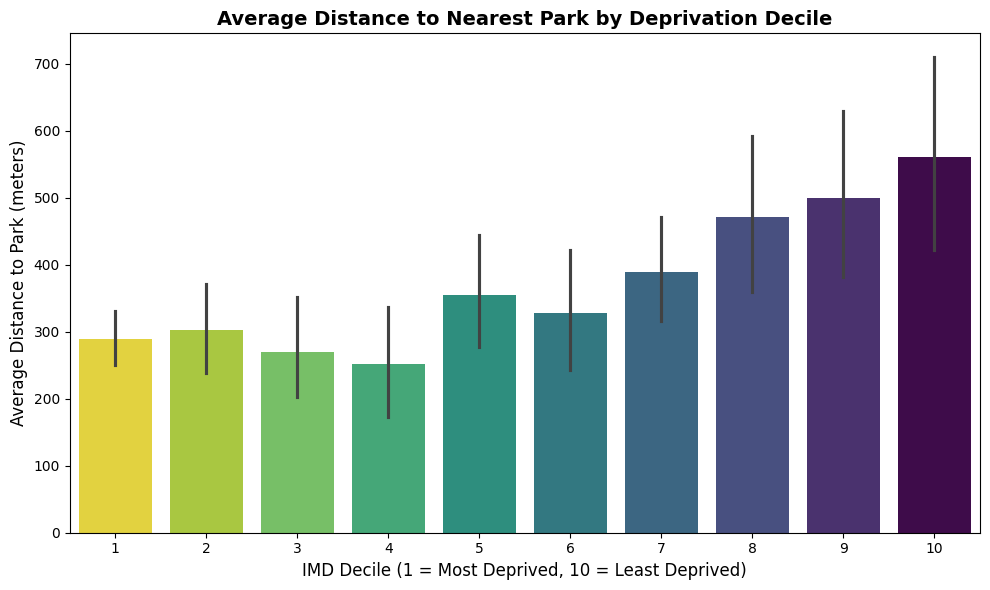

In [42]:
# Bar Plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=leeds_final,
    x='IMD_Decile',       # Horizontal axis: Poverty level
    y='dist_to_park',     # Vertical axis: distance
    hue='IMD_Decile',
    palette='viridis_r',
    legend=False,         # The horizontal axis already has labels, so no additional legend is needed
    ax=ax
)

# Set titles and tags
ax.set_title('Average Distance to Nearest Park by Deprivation Decile', fontsize=14, fontweight='bold')
ax.set_xlabel('IMD Decile (1 = Most Deprived, 10 = Least Deprived)', fontsize=12)
ax.set_ylabel('Average Distance to Park (meters)', fontsize=12)

plt.tight_layout()
plt.savefig("Analysis_1_BarPlot.png", dpi=300)
plt.show()

This bar chart illustrates the non-linear relationship between socioeconomic deprivation (IMD) and green space accessibility in Leeds. However, the poorest neighborhoods (IMD Decile 1–4) have a shorter average distance to parks (approximately 250–300 meters), while the wealthiest neighborhoods (IMD Decile 8–10) have a longer average distance (approximately 500–600 meters). This result challenges the traditional assumption of environmental equity that the wealthy possess more resources. The reason for this may be that Leeds' poorest neighborhoods are often located in densely populated, industrial-era city centers surrounded by historic municipal parks, while high-income groups tend to choose to live in less densely populated suburbs or semi-forested areas with more private gardens. Although they are physically farther from formal parks, they may have larger private gardens or closer proximity to informal natural wilderness. However, the significant differences in distance within poor areas reveal a substantial environmental divide, indicating that some disadvantaged communities still suffer from severe resource deprivation.

The error bars, represented by the black line, increase significantly with increasing wealth. In affluent areas, the distances to parks vary significantly, further illustrating the dispersed nature of suburban spatial distribution. Conversely, poorer areas have shorter error bars, indicating that these communities generally enjoy more equitable and closer access to public green spaces.

From a public interest perspective, the government should prioritize upgrading the quality and safety of existing green space facilities to compensate for insufficient per capita space with high-quality upgrades. Simultaneously, for the "green space islands" formed by the fragmentation of space in affluent suburbs, accessibility should be improved by enhancing pedestrian and bike paths.

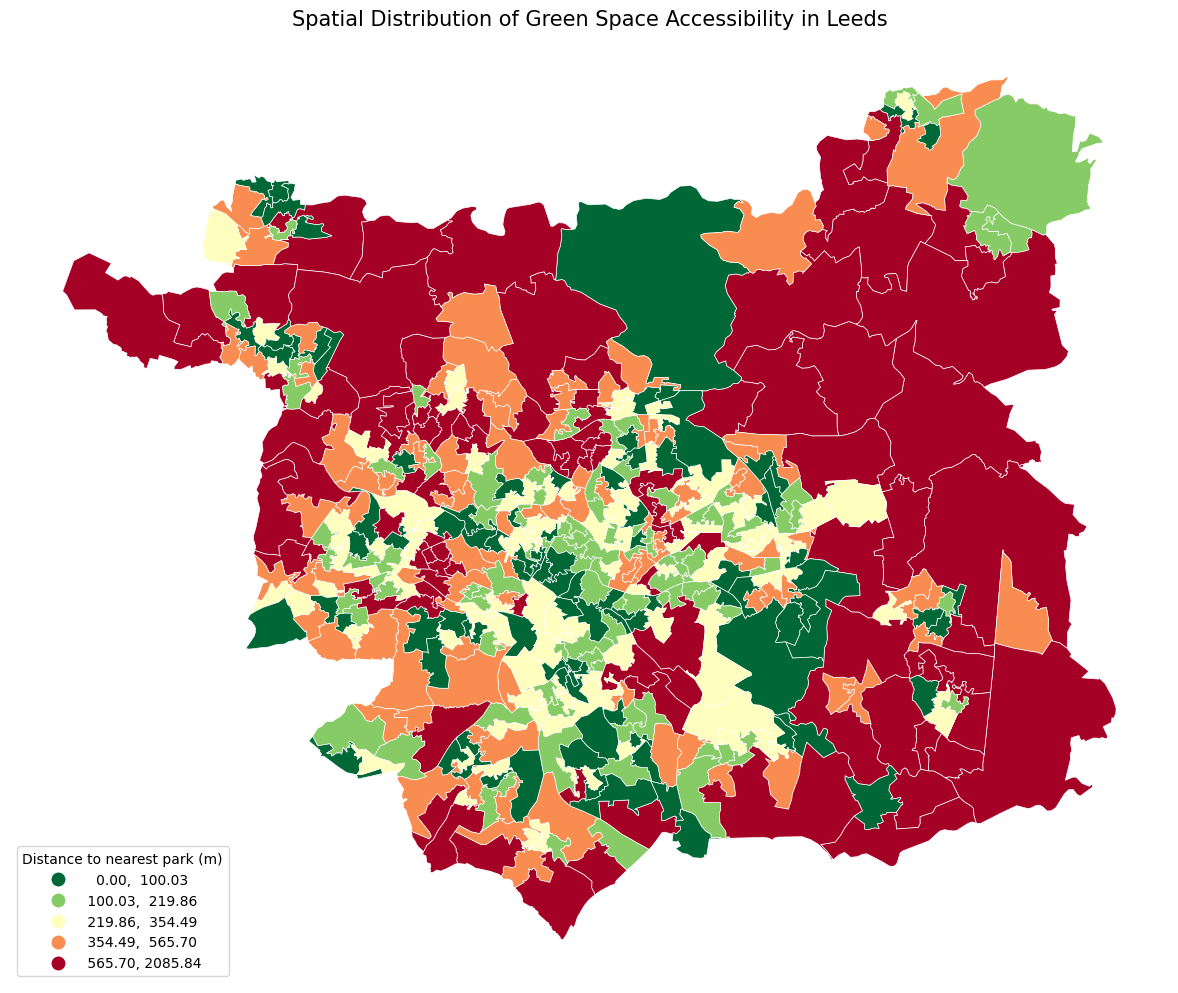

In [43]:
# Choropleth Map
plot_column = 'dist_to_park'  # Columns are distances

fig, ax = plt.subplots(figsize=(12, 10))

leeds_final.plot(
    ax=ax,
    column=plot_column,       # Data column
    cmap='RdYlGn_r',
    legend=True,              # Show legend
    legend_kwds={'title': 'Distance to nearest park (m)', 'loc': 'lower left'}, # Legend settings
    scheme='quantiles',       # Classification method: quantiles
    k=5,                      # Divided into 5 categories
    edgecolor='white',
    linewidth=0.5
)

# Set title
ax.set_title('Spatial Distribution of Green Space Accessibility in Leeds', fontsize=15)
ax.axis('off')

plt.tight_layout()
plt.savefig("Analysis_3_Map.png", dpi=300)
plt.show()

A choropleth map reveals a significant "core-periphery" pattern in Leeds' green space accessibility.

High accessibility areas (green): Primarily concentrated in Leeds city centre and surrounding established communities. These areas were urbanized earlier, have a dense distribution of parks, and residents are generally within 100 meters of the nearest green space.

Low accessibility areas (red): Widely distributed on the city's periphery, particularly in the eastern and northwestern edges. Some settlements are more than 500 meters from the nearest park, with some exceeding 2000 meters. This reflects the lagging development of public recreational facilities in the urban-rural fringe.

Policy Recommendation: It is recommended that the government allocate resources precisely to these marginal areas, making them the highest priority for future green infrastructure construction, and achieving overall environmental equity and social well-being for Leeds by addressing the shortcomings in these areas.

**Conclusion and Reflection**

This study systematically analyzed the accessibility of green space resources in Leeds by integrating geospatial data and socioeconomic indicators. The study found significant spatial differences in green space distribution in Leeds, with dense green space coverage in the city center and surrounding mature communities, easily accessible on foot. However, statistical analysis revealed a counterintuitive conclusion: in Leeds, the average distance from the poorest communities (IMD Decile 1-2) to the nearest park is approximately 300 meters, while the average distance for the wealthiest communities (IMD Decile 10) exceeds 500 meters. This suggests that, in terms of physical distance, Leeds' poorest communities are not at a disadvantage, which may be related to the historically significant public park layout in the city center.

**Spatial Inequality and Planning Recommendations:** While statistical averages indicate better accessibility in poorer areas, the spatial distribution map visually reveals the marginal crisis. The dark red areas on the map are concentrated on the city's outer edges, where residents are often more than 500 meters or further from the nearest green space. These areas have become green space deserts within the city. Therefore, for Leeds' urban planners, future resource allocation should not solely focus on the city center, but should prioritize improving green infrastructure in peripheral areas to enhance livability and achieve a higher level of social justice.

**Limitations and Areas for Improvement:** This study primarily relies on straight-line distance calculations and does not consider actual road networks, terrain barriers, or the quality of facilities within parks. Future analyses could incorporate pedestrian network analysis to obtain more realistic travel times, and combine this with data on park safety and maintenance levels to more comprehensively assess the differences in ecological welfare among different social classes. This would provide important insights for developing more scientific and equitable urban development policies.

**References**

LSOA Boundaries: Office for National Statistics (2011). Lower Layer Super Output Areas (December 2011) Boundaries EW BGC. [Online]. ONS Geography Portal. Available from: https://geoportal.statistics.gov.uk/ [Accessed 30 January 2025].

Indices of Deprivation: Ministry of Housing, Communities & Local Government (2019). File 1: index of multiple deprivation. [Online]. GOV.UK. Available from: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019 [Accessed 30 January 2025].

Green Space Data: OpenStreetMap contributors (2025). Map data retrieved via OSMnx API. [Online]. Available from: https://www.openstreetmap.org [Accessed 30 January 2025].

Environmental Inequality: Mitchell, R. and Popham, F. (2008). Effect of exposure to natural environment on health inequalities: an observational population study. The Lancet, 372(9650), pp.1655-1660.

Green Space & Health: World Health Organization (2016). Urban green spaces and health. [Online]. Copenhagen: WHO Regional Office for Europe. Available from: https://www.who.int/europe/publications/i/item/9789289051491 [Accessed 30 January 2025].

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [48]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/GEOG5415M Programming for Spatial Data Science.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/GEOG5415M Programming for Spatial Data Science.ipynb to pdf
[NbConvertApp] Support files will be in GEOG5415M Programming for Spatial Data Science_files/
[NbConvertApp] Making directory ./GEOG5415M Programming for Spatial Data Science_files
[NbConvertApp] Writing 52214 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 471702 bytes to /content/drive/MyDrive/Colab Notebooks/GEOG5415M Programming for Spatial Data Science.pdf
